Theory of the fit:  
https://en.wikipedia.org/wiki/Non-negative_least_squares  
https://en.wikipedia.org/wiki/Tikhonov_regularization

#### Import modules

In [48]:
import pandas as pd
import numpy as np
import scipy.optimize
import csv
import os
import collections
from uncertainties import ufloat
from IPython.display import display, Markdown, display_html
from collections import OrderedDict
from pyexcel_ods import save_data

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

#### plotly settings:

In [49]:
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

#### Specify data folder and names

In [50]:
inFolder = './data/'
dataDict = {'Slot1': {}, 'Slot2': {}, 'Slot3': {}}

doseDf = pd.read_table('doses.dat', comment='#')
doseDf[doseDf < 0] = np.nan
display( doseDf )

realDose = list( doseDf['EPD/R'] ) 
realDoseConv = [173.15, 191.07, 226.55, 688.03, 376.64, 154.8, 169.73]
epdDose = list( doseDf['EPD'] ) 
epdDoseConv = [187, 214, 265, 569, 403, 150, 166]
energyListFile = list( doseDf['Energy'] )
energyListConv = [16.4, 20.3, 24.7, 47.9, 65, 83.1, 100]

# Fit with error?

Energy     DPX  DPX_err    EPD   EPD/R
0     16.4  255.80     7.60  187.0  173.15
1     20.3  196.98     3.33  214.0  191.07
2     24.7  236.67     3.82  265.0  226.55
3     47.9  591.30     2.05  569.0  688.03
4     65.0  363.38     2.05  403.0  376.64
5     83.1  155.32     1.63  150.0  154.80
6    100.0  186.53     2.01  166.0  169.73
7    117.7  368.07    20.92  321.0  328.22
8    164.0  135.34    10.21  127.5  122.60
9    207.5  139.65    10.56  133.5  124.77
10   248.9  130.17    10.50  127.0  117.59
11   286.7  123.79    10.72  117.0     NaN
12   324.1  103.02    10.07   99.0     NaN

#### Combine the entries of all small and large pixels

**TODO**: At the moment only large pixels are returned!

In [51]:
def combineBins(df, large=True):    
    smallIdx, largeIdx = 4, 12
    idx = 2
    
    smallDf = pd.DataFrame()
    largeDf = pd.DataFrame()
    
    smallDf = smallDf.append(df.iloc[0:idx])
    while idx < 255:
        largeDf = largeDf.append(df.iloc[idx:idx+largeIdx])
        idx += largeIdx
        smallDf = smallDf.append(df.iloc[idx:idx+smallIdx])
        idx += smallIdx
        
    if large:
        return largeDf.sum(axis=0)
    else:
        return smallDf.sum(axis=0)

#### Return the combined pixel data for all files in the input folder

In [52]:
def getCombinedBins(inFolder, large=True):
    for fn in os.listdir(inFolder):
        if os.path.isfile(inFolder + fn) and fn.endswith('.csv'):
            slotType, energy = fn.split('.')[0].split('_')
            energy = int(energy.split('kV')[0])
            # print(slotType, energy)

            df = pd.read_csv(inFolder + fn, header=None)
            df = combineBins(df, large=large)

            dataDict[slotType][energy] = df

    return dataDict

#### Combine the number of counts into one list in the returned *dataDict* of *getCombinedBins()*

In [53]:
def getCounts(dataDict, energy):
    countList = []
    for i in range(1, 3 + 1):
        countList += list(dataDict['Slot%d' % i][energy])
    
    return countList

#### Load conversion factors from file

In [54]:
def getConversionFactors(inFile):
    df = pd.read_csv(inFile, header=None)
    conversionList = []
    for i in range(3):
        conversionList += list( df[i] )
        
    return np.array( conversionList )

#### Calculate dose from loaded conversion factors

In [55]:
dataDict = getCombinedBins(inFolder, large=False)

energyList = []
energyCounts = []

for key in sorted(dataDict['Slot1']):
    energyList.append( key )
    energyCounts.append( getCounts(dataDict, key) )
energyCounts = np.array( energyCounts )
energyCountsErr = np.sqrt( energyCounts )

# print( np.array(energyCounts) )
conversionFactors = getConversionFactors('conversion.csv')

dose = np.dot(energyCounts, conversionFactors)
doseErr = np.sqrt( np.dot(np.square(energyCountsErr), np.square(conversionFactors)) )
doseUnc = [ufloat(dose[i], doseErr[i]) for i in range(len(dose))]

showDf = pd.DataFrame(np.transpose([energyList, energyListFile, doseUnc]), columns=['Energy', 'Mean energy', 'Dose'])
display( showDf )

Energy Mean energy           Dose
0      20        16.4  4.687+/-0.020
1      25        20.3  4.104+/-0.024
2      30        24.7  5.600+/-0.030
3      60        47.9   13.79+/-0.07
4      80          65    7.73+/-0.06
5     100        83.1    3.29+/-0.05
6     120         100    4.03+/-0.06
7     150       117.7    8.11+/-0.08
8     200         164    3.03+/-0.05
9     250       207.5    3.03+/-0.06
10    300       248.9    2.66+/-0.05
11    350       286.7    2.62+/-0.05
12    400       324.1    2.14+/-0.05

#### Fit conversion factors

See https://scicomp.stackexchange.com/questions/10671/tikhonov-regularization-in-the-non-negative-least-square-nnls-pythonscipy  
for fit of underdetermined matrix

In [40]:
def fitConversion(H, y, gamma=.1, minBound=1.e-6, alphaBounds=False, alphaInit=None, werr=False):
    C = np.concatenate((H, gamma*np.identity(len(H[0]))), axis=0)
    d = np.concatenate((y, np.zeros(len(H[0]))), axis=0)
    
    def fitFunc(x, H, y, werr=werr):
        if werr:
            return 1./np.sqrt(np.dot(H, np.square(x))) * np.abs(np.dot(H, x) - y)
        else:
            return np.abs(np.dot(H, x) - y)
    
    if alphaBounds and list(alphaInit):
        alphaInit[alphaInit < 0] = 0
        # return scipy.optimize.lsq_linear(C, d, bounds=alphaBounds)['x']
        return scipy.optimize.least_squares(fitFunc, x0=np.array(alphaInit), args=(C, d), bounds=alphaBounds)['x']
    elif minBound == 0:
        return scipy.optimize.nnls(C, d)[0]
    else:
        return scipy.optimize.lsq_linear(C, d, bounds=(minBound, np.inf))['x']

#### Print dose estimated via fitted conversion factors

In [41]:
gamma = 0.01
minVal = 0
fac = 0.9

alphaBounds = np.array( [(fac*conv, (1+(1-fac))*conv) if conv > 0 else (0, np.inf) for conv in conversionFactors] )
alphaBounds = (list(alphaBounds[:,0]), list(alphaBounds[:,1]))

# Remove nan values
realDoseFilt, energyCountsFilt, energyListFilt, energyListFileFilt, energyCountsFilt = [], [], [], [], []
for i, doseItem in enumerate(realDose):
    if not np.isnan(doseItem):
        realDoseFilt.append( doseItem )
        energyCountsFilt.append( energyCounts[i] )
        energyListFilt.append( energyList[i] )
        energyListFileFilt.append( energyListFile[i] )

print(len(energyCountsFilt), len(realDoseFilt))
fittedConversionFactors = fitConversion(energyCountsFilt, realDoseFilt, gamma, minVal, alphaBounds, conversionFactors, werr=False)
oldDf = pd.DataFrame(np.transpose(conversionFactors.reshape(3, 16)), columns = ['Slot%d' % i for i in range(1, 4)])
outDf = pd.DataFrame(np.transpose(fittedConversionFactors.reshape(3, 16)), columns = ['Slot%d' % i for i in range(1, 4)])
outDf.to_csv('conversionFit_woerror.csv', header=None, index=False)

if alphaBounds:
    display(Markdown('Fitted conversion factors using preset factors and a boundary factor of %.1f:  \n**Left:** old, **Right:** fitted' % fac))
else:
    display(Markdown('Fitted conversion factors (Gamma = %.2f, Minimum = %.2f):' % (gamma, minVal)))
display_side_by_side( oldDf, outDf )
print()

# Dose calculated with fitted conversion factors
doseFit = np.dot(energyCountsFilt, fittedConversionFactors)
doseFitErr = np.sqrt( np.dot(np.square(energyCountsErr), np.square(fittedConversionFactors)) )
doseFitUnc = [ufloat(doseFit[i], doseFitErr[i]) for i in range(len(doseFit))]

epdDose = epdDose[:len(doseFit)]
dose = dose[:len(doseFit)]

print(len(energyListFilt), len(realDoseFilt), len(doseFit), len(doseFitUnc), len(energyListFileFilt), len(dose))
energyList, realDose, energyListFile, energyCounts = energyListFilt, realDoseFilt, energyListFileFilt, energyCountsFilt
doseDf = pd.DataFrame(np.transpose([energyList, realDose, doseFitUnc, np.array(doseFitUnc)/np.array(realDose)]),
                       columns=['Energy [keV]', 'Dose (set)', 'Dose (fit)', 'fit/set'])
doseDf = doseDf.dropna()
display(doseDf)

11 11


Fitted conversion factors using preset factors and a boundary factor of 0.9:  
**Left:** old, **Right:** fitted

Slot1 
 Slot2 
 Slot3 
 
 
 
 
 0 
 0.002171 
 0.007387 
 0.000285 
 
 
 1 
 0.002262 
 0.005770 
 0.000000 
 
 
 2 
 0.002392 
 0.002779 
 0.000000 
 
 
 3 
 0.001639 
 0.003638 
 0.000000 
 
 
 4 
 0.000773 
 0.002092 
 0.000000 
 
 
 5 
 0.001357 
 0.001789 
 0.001386 
 
 
 6 
 0.000683 
 0.001132 
 0.002413 
 
 
 7 
 0.000445 
 0.000682 
 0.001704 
 
 
 8 
 0.000182 
 0.000377 
 0.001879 
 
 
 9 
 0.000101 
 0.000358 
 0.001899 
 
 
 10 
 0.000034 
 0.000223 
 0.001869 
 
 
 11 
 0.000027 
 0.000182 
 0.001653 
 
 
 12 
 0.000024 
 0.000145 
 0.001263 
 
 
 13 
 0.000024 
 0.000137 
 0.000992 
 
 
 14 
 0.000029 
 0.000113 
 0.000967 
 
 
 15 
 0.000018 
 0.000341 
 0.000757 
 
 
 
 
 
 
 Slot1 
 Slot2 
 Slot3 
 
 
 
 
 0 
 0.001954 
 0.006648 
 2.568898e-04 
 
 
 1 
 0.002036 
 0.005193 
 6.201897e-12 
 
 
 2 
 0.002153 
 0.002501 
 4.690037e-12 
 
 
 3 
 0.001475 
 0.004002 
 1.058312e+02 
 
 
 4 
 0.000696 
 0.001883 
 3.549242e+01 
 
 
 5 
 0.001493 
 0.001967 
 1.247487e-03 
 
 
 6 
 0.000751 
 0.001245 
 2.654118e-03 
 
 
 7 
 0.000490 
 0.000750 
 1.874824e-03 
 
 
 8 
 0.000200 
 0.000415 
 2.066824e-03 
 
 
 9 
 0.000111 
 0.000393 
 2.089412e-03 
 
 
 10 
 0.000038 
 0.000246 
 2.055529e-03 
 
 
 11 
 0.000029 
 0.000200 
 1.818353e-03 
 
 
 12 
 0.000026 
 0.000159 
 1.389176e-03 
 
 
 13 
 0.000026 
 0.000151 
 1.091012e-03 
 
 
 14 
 0.000032 
 0.000124 
 1.063906e-03 
 
 
 15 
 0.000020 
 0.000375 
 8.323765e-04


11 11 11 11 11 11


Energy [keV] Dose (set)       Dose (fit)            fit/set
0            20     173.15  (1.1+/-1.1)e+02          0.6+/-0.6
1            25     191.07    4.515+/-0.026  0.02363+/-0.00014
2            30     226.55    6.160+/-0.033  0.02719+/-0.00014
3            60     688.03     15.17+/-0.07  0.02205+/-0.00010
4            80     376.64      8.50+/-0.07  0.02257+/-0.00018
5           100      154.8      3.62+/-0.05  0.02340+/-0.00033
6           120     169.73      4.43+/-0.06    0.0261+/-0.0004
7           150     328.22      8.92+/-0.09  0.02718+/-0.00027
8           200      122.6  (1.1+/-0.6)e+02          0.9+/-0.5
9           250     124.77          39+/-35        0.31+/-0.28
10          300     117.59  (1.8+/-1.2)e+02          1.5+/-1.0

#### Merge two alphas together

-54.870551679


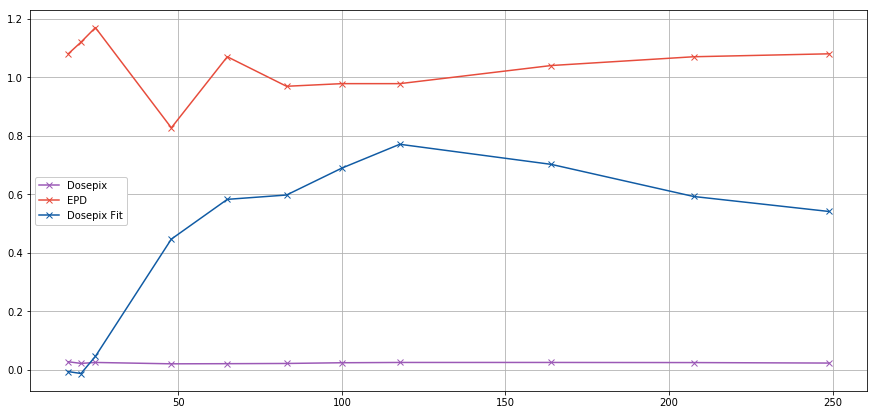

In [42]:
conversionFactors1 = getConversionFactors('conversionFitSimThilo.csv')
conversionFactors2 = getConversionFactors('conversionFitSimIna.csv')

# Use previously defined variables 'conversionFactors' and 'conversionFactors2' in the combination
def mixAlpha(alpha1, alpha2, p):
    return p * np.array(alpha1) + (1-p) * np.array(alpha2)

def fitMix(H, y, alpha1, alpha2):
    C = np.concatenate((H, gamma*np.identity(len(H[0]))), axis=0)
    d = np.concatenate((y, np.zeros(len(H[0]))), axis=0)
    
    def fitFunc(p, H, y, alpha1, alpha2): 
        alphaMix = mixAlpha(alpha1, alpha2, p)
        
        return np.abs(np.dot(H, alphaMix) - y)
    
    return scipy.optimize.least_squares(fitFunc, x0=0.1, args=(H, y, alpha1, alpha2))['x']

pFit = fitMix(energyCountsFilt, realDoseFilt, conversionFactors1, conversionFactors2)[0]
print(pFit)
alphaMix = mixAlpha(conversionFactors, conversionFactors2, pFit)

# Plot
fig, ax = plt.subplots(figsize=[15, 7])
cmapList = ['#9b59b6', '#e74c3c'] + list(reversed( sns.color_palette('Blues', 5).as_hex() ))

newDose = np.dot(energyCountsFilt, alphaMix)
ax.plot(energyListFile, np.array(dose)/np.array(realDose), marker='x', label='Dosepix', color=cmapList[0])
ax.plot(energyListFile, np.array(epdDose)/np.array(realDose), marker='x', label='EPD', color=cmapList[1])
ax.plot(energyListFile, np.array(newDose)/np.array(realDose), marker='x', label='Dosepix Fit', color=cmapList[2])

plt.grid()
leg = plt.legend(frameon=True)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1)
plt.draw()

#### Dose ratio plot  
Uses the constraints set by the loaded conversion factors.

In [43]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.colors import ListedColormap

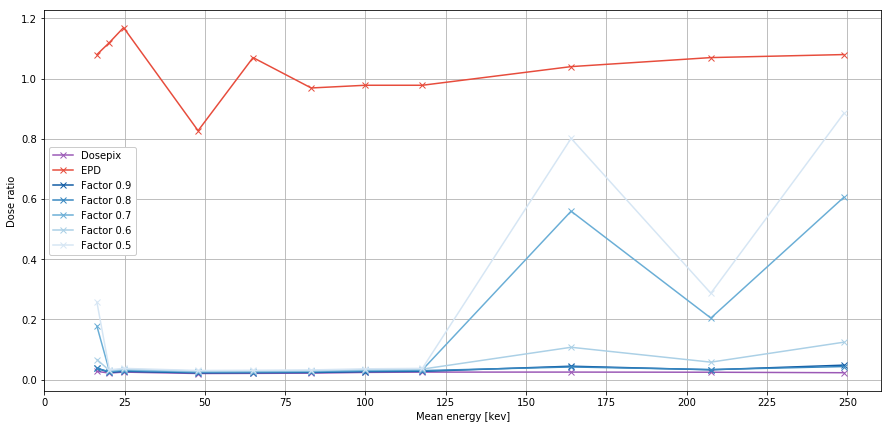

In [44]:
# Init plot
fig, ax = plt.subplots(figsize=[15, 7])
cmapList = ['#9b59b6', '#e74c3c'] + list(reversed( sns.color_palette('Blues', 5).as_hex() ))
ax.plot(energyListFile, np.array(dose)/np.array(realDose), marker='x', label='Dosepix', color=cmapList[0])
ax.plot(energyListFile, np.array(epdDose)/np.array(realDose), marker='x', label='EPD', color=cmapList[1])

energyListList = [energyListFile, np.array(dose)/np.array(realDose), np.array(epdDose)/np.array(realDose)]
columnList = ['Mean energy [keV]', 'Dosepix', 'EPD']
gamma = 0.01
for i, fac in enumerate(reversed(np.arange(.5, 1., .1))):
    alphaBounds = np.array( [(conv*fac, conv*(1+(1-fac))) if conv > 0 else (0, np.inf) for conv in conversionFactors] )
    alphaBounds = (list(alphaBounds[:,0]), list(alphaBounds[:,1]))
    fittedConversionFactors = fitConversion(energyCounts, realDose, gamma, minVal, alphaBounds, conversionFactors, werr=True)
    doseFit = np.dot(energyCounts, fittedConversionFactors)
    energyListList.append( np.array(doseFit)/np.array(realDose) )
    
    columnList.append('Factor %.1f' % fac)
    
    ax.plot(energyListFile, np.array(doseFit)/np.array(realDose), marker='x', label='Factor %.1f' % fac, color=cmapList[i+2])
     
dosePlotDf = pd.DataFrame(np.transpose(energyListList), columns=columnList)
dosePlotDf = dosePlotDf.melt('Mean energy [keV]', var_name='Type',  value_name='Dose ratio')

# Seaborn plot
# pal = sns.color_palette( cmapList )
# sns.pointplot(x='Mean energy [keV]', y='Dose ratio', hue='Type', data=dosePlotDf, palette=pal, fig=fig)

ax.set_ylabel('Dose ratio')
ax.set_xlabel('Mean energy [kev]')

# Tick frequency
ax.xaxis.set_ticks(np.arange(0, 250 + 25, 25))

plt.grid()
leg = plt.legend(frameon=True)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1)
plt.draw()

#### Dependency of errors on factor gamma

In [45]:
doseRMS, doseErrRMS = [], []
alphaBounds = np.array( [(0.5*conv, 1.5*conv) if conv > 0 else (0, np.inf) for conv in conversionFactors] )
alphaBounds = (list(alphaBounds[:,0]), list(alphaBounds[:,1]))

gammaList = np.logspace(-10, 5, 200)
for gamma in gammaList:
    fittedConversionFactors = fitConversion(energyCounts, realDose, gamma, 1.e-5, alphaBounds)
    doseFit = np.dot(energyCounts, fittedConversionFactors)
    doseRMS.append( np.sqrt(np.sum(np.square(doseFit - realDose))) ) 
    doseFitErr = np.sqrt( np.dot(np.square(energyCountsErr), np.square(fittedConversionFactors)) )
    doseErrRMS.append( np.sqrt(np.sum(np.square(doseFitErr))) )


sns.pointplot(x='Mean energy [keV]', y='Dose ratio', hue='Type', data=dosePlotDf, palette=pal, fig=fig)

doseRMSPoints = go.Scatter(
    x=gammaList, 
    y=doseRMS,
    name='Residual RMS'
)

doseErrRMSPoints = go.Scatter(
    x=gammaList, 
    y=doseErrRMS,
    name='Error RMS'
)

data = [doseRMSPoints, doseErrRMSPoints]
layout = go.Layout(
    xaxis=dict(
        type='log',
        autorange=True
    ),
    yaxis=dict(
        type='log',
        autorange=True
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

TypeError: 'NoneType' object is not iterable

In [56]:
data = OrderedDict()
print(energyListFile)

for i in range(1, 3+1):
    header = []
    energyMatrix = []
    energyMatrix.append(['Energy', 'Mean energy'] + ['Bin%d' % j for j in range(16)])
    k = 0
    for key, item in collections.OrderedDict(sorted(dataDict['Slot%d' % i].items())).items():
        header.append( key )
        try:
            energyMatrix.append( [key, float(energyListFile[k])] + list([int(it) for it in item]) )
        except:
            break
        k += 1
        
    data.update({'Slot%d' % i: energyMatrix})
    # data.update({'Sheet%d' % i: np.transpose(energyMatrix)})
    display(pd.DataFrame( np.transpose(energyMatrix) ))
    
save_data("smallPixel.ods", data)

[16.399999999999999, 20.300000000000001, 24.699999999999999, 47.899999999999999, 65.0, 83.099999999999994, 100.0, 117.7, 164.0, 207.5, 248.90000000000001, 286.69999999999999, 324.10000000000002]


0      1      2      3      4     5     6      7      8      9   \
0        Energy     20     25     30     60    80   100    120    150    200   
1   Mean energy   16.4   20.3   24.7   47.9  65.0  83.1  100.0  117.7  164.0   
2          Bin0      0      0      0      0     0     0      0      0      0   
3          Bin1      0      0      0      0     0     0      0      0      0   
4          Bin2      0      0      0      0     0     0      0      0      0   
5          Bin3      0      0      0      0     0     0      0      0      0   
6          Bin4      0      0      0      0     0     0      0      0      0   
7          Bin5      0      0      0      0     0     0      0      0      2   
8          Bin6      0      0      0      0     1     0      3     21      7   
9          Bin7      0      0      0      1     1     2     52     85     24   
10         Bin8      0      0      0      0     0   127    152    246     46   
11         Bin9      0      0      0      3   383   377    299    406     96   
12        Bin10      0      0      0    503  2562   614    450    544    196   
13        Bin11      0      1      0   7464  3360   552    383    578    239   
14        Bin12      0      0      0  17627  3319   603    502   1122    390   
15        Bin13      1   1600  16095  16338  3666   821   1093   2171    640   
16        Bin14  95593  57017  40539  15046  4946  2080   2259   3866    948   
17        Bin15  34558  12617   9743   7308  3694  1285   1271   1976    440   

       10     11     12     13  
0     250    300    350    400  
1   207.5  248.9  286.7  324.1  
2       0      0      0      0  
3       0      0      0      0  
4       0      0      0      0  
5       0      0      0      0  
6       0      0      0      2  
7       3      1      9      3  
8       5     18     21     16  
9      22     45     40     42  
10     75     96     98     77  
11    124    132    124     96  
12    222    178    192    133  
13    235    220    189    154  
14    296    283    266    198  
15    513    427    375    287  
16    788    546    483    403  
17    372    260    233    150

0     1     2      3      4     5     6      7      8      9   \
0        Energy    20    25     30     60    80   100    120    150    200   
1   Mean energy  16.4  20.3   24.7   47.9  65.0  83.1  100.0  117.7  164.0   
2          Bin0     0     0      0      0     0     0      0      0      0   
3          Bin1     0     0      0      0     0     0      0      0      0   
4          Bin2     0     0      0      0     0     0      0      0      0   
5          Bin3     0     0      0      0     0     0      0      0      1   
6          Bin4     0     0      0      0     0     0      0      0      0   
7          Bin5     0     0      0      0     0     0      0      5      3   
8          Bin6     0     0      0      0     0     0      7     37     15   
9          Bin7     0     0      0      0     0     8     71    120     20   
10         Bin8     0     0      0      1     8   189    184    287     52   
11         Bin9     0     0      0      1   772   412    298    374     89   
12        Bin10     0     0      0   1410  2865   604    412    531    206   
13        Bin11     0     0      0  10416  3296   615    428    650    293   
14        Bin12     0     0      4  14915  3031   595    573   1193    411   
15        Bin13     6  1868  10623  10963  3111   841   1052   1982    482   
16        Bin14  5337  8450   8417   9204  3184  1413   1564   2513    599   
17        Bin15  2075  2741   4024   6786  3634  1427   1372   2088    504   

       10     11     12     13  
0     250    300    350    400  
1   207.5  248.9  286.7  324.1  
2       0      0      0      0  
3       0      0      0      0  
4       0      0      0      0  
5       1      1      0      0  
6       0      3      2      8  
7       2      9     11     12  
8       9     22     25     35  
9      39     50     57     44  
10     79     73     68     82  
11    126    121    116     92  
12    186    162    150    131  
13    215    230    189    154  
14    348    283    255    206  
15    445    357    270    236  
16    467    377    302    230  
17    423    273    244    196

0     1     2     3     4     5     6      7      8      9   \
0        Energy    20    25    30    60    80   100    120    150    200   
1   Mean energy  16.4  20.3  24.7  47.9  65.0  83.1  100.0  117.7  164.0   
2          Bin0     0     0     0     0     0     0      0      0      0   
3          Bin1     0     0     0     0     0     0      0      0      0   
4          Bin2     0     0     0     0     0     0      0      0      0   
5          Bin3     1     0     0     0     0     0      0      0      0   
6          Bin4     0     0     0     0     0     0      0      0      3   
7          Bin5     0     0     0     0     0     0      0      0      2   
8          Bin6     0     0     0     0     0     0      2      7      5   
9          Bin7     0     0     0     0     0     1      4     16     20   
10         Bin8     0     0     0     0     1     1     16     63     33   
11         Bin9     0     0     0     0     3    24     62    139     77   
12        Bin10     0     0     0     0    18    52     95    231    112   
13        Bin11     0     0     0     2    75   131    160    286    146   
14        Bin12     0     0     0    15   234   126    170    308    140   
15        Bin13     0     0     0   151   436   162    186    392    200   
16        Bin14     0     0     0   616   478   146    205    528    255   
17        Bin15     5    71   122  2920  2374  1237   1745   4019   1372   

       10     11     12     13  
0     250    300    350    400  
1   207.5  248.9  286.7  324.1  
2       0      0      0      0  
3       0      0      0      2  
4       0      0      0      1  
5       0      1      1      0  
6       1      2      4      2  
7       2      6      6     10  
8      12     10     23     15  
9      28     20     37     31  
10     61     61     63     68  
11    103     97     99     92  
12    118     96     92     74  
13    153    122    133    104  
14    161    149    142    103  
15    193    178    162    120  
16    201    228    226    160  
17   1276   1001    922    723